# Imports

In [117]:
import pandas as pd
import numpy as np

import os
import json
from functools import partial

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

# Load Dataset
Sử dụng 2 tập Dataset từ Kaggle:
- TMDB 5000 Credits
- TMDB 5000 Movies

In [118]:
PATH = "../data/"
print(os.listdir(PATH))

['count_matrix.npz', 'movie_df.pickle', 'movie_scores.pickle', 'tfidf_matrix.npz', 'the_movies_dataset', 'tmdb_5000_credits.csv', 'tmdb_5000_movies.csv', 'tmdb_5000_movie_dataset']


In [119]:
credits = pd.read_csv(os.path.join(PATH, 'tmdb_5000_credits.csv'))
movies = pd.read_csv(os.path.join(PATH, 'tmdb_5000_movies.csv'))

In [120]:
credits[['title', 'cast', 'crew']].head(5)

,title,cast,crew
0,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [121]:
movies[['title', 'genres', 'keywords', 'popularity', 'production_companies', 'revenue', 'budget', 'vote_average', 'vote_count']].head(3)

,title,genres,keywords,popularity,production_companies,revenue,budget,vote_average,vote_count
0,Avatar,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",2787965087,237000000,7.2,11800
1,Pirates of the Caribbean: At World's End,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",961000000,300000000,6.9,4500
2,Spectre,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",880674609,245000000,6.3,4466


In [122]:
# merge this two dataset
credits.columns = ['id', 'tittle','cast','crew']
movie_df = movies.merge(credits, on='id');
del credits
del movies

In [123]:
movie_df[['title', 'genres', 'keywords', 'popularity', 'production_companies', 'revenue', 'budget', 'vote_average', 'vote_count', 'cast', 'crew']].head(3)

,title,genres,keywords,popularity,production_companies,revenue,budget,vote_average,vote_count,cast,crew
0,Avatar,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",2787965087,237000000,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,Pirates of the Caribbean: At World's End,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",961000000,300000000,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,Spectre,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",880674609,245000000,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


# Data Preparation
- Chuyển đổi định dạng dữ liệu
- Thêm những cột dữ liệu quan trọng

In [124]:
# Chuyển định dạng json của một vài cột về định dạng array
json_columns = {'cast', 'crew', 'genres', 'keywords', 'production_countries', 
                'production_companies', 'spoken_languages'}

for c in json_columns:
    movie_df[c] = movie_df[c].apply(json.loads)
    if c != "crew": # Cần thêm những dữ liệu khác ngoài name
        movie_df[c] = movie_df[c].apply(lambda row: [x["name"] for x in row])

In [125]:
# Tạo 3 cột "Đạo diễn", "Biên kịch" và "Nhà sản xuất" của bộ phim
def get_job(job, row):
    person_name = [x['name'] for x in row if x['job']==job] 
    return person_name[0] if len(person_name) else np.nan

movie_df["director"] = movie_df["crew"].apply(partial(get_job, "Director"))
movie_df["writer"]   = movie_df["crew"].apply(partial(get_job, "Writer"))
movie_df["producer"] = movie_df["crew"].apply(partial(get_job, "Producer"))
del movie_df["crew"]

In [126]:
# Tạo cột "Lợi nhuận" của bộ phim
movie_df["profit"] = movie_df["revenue"] - movie_df["budget"]

In [127]:
movie_df[['title', 'genres', 'keywords', 'director', 'writer', 'producer', 'popularity', 'production_companies', 'profit', 'vote_average', 'vote_count', 'cast']].head(1)

,title,genres,keywords,director,writer,producer,popularity,production_companies,profit,vote_average,vote_count,cast
0,Avatar,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...",James Cameron,James Cameron,James Cameron,150.437577,"[Ingenious Film Partners, Twentieth Century Fo...",2550965087,7.2,11800,"[Sam Worthington, Zoe Saldana, Sigourney Weave..."


# Recommendation System

## Weighted Average
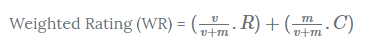
- v là số lượng vote của bộ phim;
- m số lượng vote tối thiểu cần có;
- R là giá trị vote trung bình của bộ phim;
- C là giá trị trung bình vote của cả dataset.

In [128]:
C = movie_df['vote_average'].mean()
C

6.092171559442016

In [129]:
m = movie_df['vote_count'].quantile(0.9)
m

1838.4000000000015

In [130]:
quality_movies = movie_df.copy().loc[movie_df['vote_count'] >= m]
quality_movies.shape

(481, 26)

In [131]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Tính toán dựa trên công thức của IMDB Score:
    return (v/(v+m) * R) + (m/(m+v) * C)

Demo bảng dữ liệu Score sau khi đã sắp xếp

In [132]:
quality_movies['score'] = quality_movies.apply(weighted_rating, axis=1)
quality_movies = quality_movies.sort_values('score', ascending=False)
quality_movies[['title', 'vote_count', 'vote_average', 'score']].head(5)

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239


## Content Based
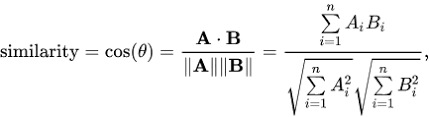
- Sử dụng công thức Cosine Similarity để tính toán sự tương đồng giữa các bộ phim
- Tính toán trên ma trận đã embed các thông tin feature của phim

In [133]:
movie_df['overview'].head(3)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
Name: overview, dtype: object

In [134]:
# Sử dụng TF-IDF (term frequency–inverse document frequency) để vector hoá dữ liệu
# TF-IDF là phương pháp thống kê để cho chúng ta biết độ quan trọng của một từ trong 1 tập lớn các từ
tfidf = TfidfVectorizer(stop_words='english')

movie_df['overview'] = movie_df['overview'].fillna('')

tfidf_matrix = tfidf.fit_transform(movie_df['overview'])
tfidf_matrix.shape

(4803, 20978)

In [135]:
# Thay vì dùng cosine thì sử dụng linear sẽ nhanh hơn, do dữ liệu đã được vector hoá bởi TF-IDF
# Chỉ cần nhân tích vô hướng là được giá trị consine
# Ta thu được ma trận consine_sim là ma trận tính toán độ tương đồng giữa các phim
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
indices = pd.Series(movie_df.index, index=movie_df['title']).drop_duplicates()

In [136]:
# Hàm lấy top 10 bộ phim có giá trị tương đồng nhất với title
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    movie_similarity = [i[1] for i in sim_scores]

    return pd.DataFrame(zip(movie_df['title'].iloc[movie_indices], movie_similarity), columns=["title", "similarity"])

Demo Ma trận tương đồng

In [137]:
get_recommendations('The Dark Knight Rises')

,title,similarity
0,The Dark Knight,0.301512
1,Batman Forever,0.298570
2,Batman Returns,0.287851
3,Batman,0.264461
4,"Batman: The Dark Knight Returns, Part 2",0.185450
5,Batman Begins,0.167996
6,Slow Burn,0.166829
7,Batman v Superman: Dawn of Justice,0.133740
8,JFK,0.132197
9,Batman & Robin,0.130455


In [138]:
get_recommendations('The Avengers')

,title,similarity
0,Avengers: Age of Ultron,0.146374
1,Plastic,0.122791
2,Timecop,0.110385
3,This Thing of Ours,0.107529
4,Thank You for Smoking,0.106203
5,The Corruptor,0.097598
6,Wall Street: Money Never Sleeps,0.094084
7,Team America: World Police,0.092244
8,The Fountain,0.086643
9,Snowpiercer,0.086189


## Content Based (more Feature)
- Sử dụng thêm nhiều feature như: dàn diễn viên, keywords, thể loại, đạo diễn, biên kịch, nhà sản xuất, . . .
- Tính toán ra một ma trận tương đồng mới để dự đoán gợi ý phim

In [139]:
# Lấy ra top 5 giá trị của những cột sau
features = ['cast', 'keywords', 'genres']
top_num = 5
for feature in features:
    movie_df[feature] = movie_df[feature].apply(lambda x: x[:top_num] if isinstance(x, list) else [])

In [140]:
# Chuẩn hoá những giá trị tên
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    elif isinstance(x, str):
        return str.lower(x.replace(" ", ""))
    else:
        return ''
    
features = ['cast', 'keywords', 'genres', 'director', "writer", "producer", "production_companies", "production_countries"]

for feature in features:
    movie_df[feature] = movie_df[feature].apply(clean_data)

In [141]:
# Tạo ra metadata-soup để việc embed diẽn ra được tốt hơn
def create_joined_features(x):
    return ' '.join([' '.join(x[f]) if isinstance(x[f], list) else str(x[f]) for f in features])

movie_df["join_features"] = movie_df.apply(create_joined_features, axis=1)

In [142]:
# Sử dụng Count Vectorizer để embed những feature 
# Count Vectorizer sẽ chuyển một văn bản nhất định về một vector cơ sở tần suất (số lượng - count)
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(movie_df['join_features'])
count_matrix.shape

(4803, 24176)

In [143]:
# Ở đây, ta cần sử dụng Consine Similarity vì không còn sử dụng TF-IDF nữa
# Sau khi tính toán tương đồng, ta được một ma trận tương đồng mới cosine_sim2
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

movie_df = movie_df.reset_index()
indices = pd.Series(movie_df.index, index=movie_df['title'])

Demo Ma trận tương đồng mới

In [144]:
get_recommendations('The Dark Knight Rises', cosine_sim2)

,title,similarity
0,The Dark Knight,0.741941
1,Batman Begins,0.684737
2,The Prestige,0.428571
3,Interstellar,0.398410
4,Inception,0.392792
5,Man of Steel,0.364013
6,Amidst the Devil's Wings,0.356348
7,Suicide Squad,0.329914
8,Harper,0.327327
9,Harsh Times,0.327327


In [145]:
get_recommendations('The Avengers', cosine_sim2)

,title,similarity
0,Avengers: Age of Ultron,0.804030
1,Iron Man 2,0.628828
2,Captain America: The Winter Soldier,0.611111
3,Captain America: Civil War,0.540621
4,Thor: The Dark World,0.514496
5,Captain America: The First Avenger,0.514496
6,Ant-Man,0.514496
7,The Incredible Hulk,0.474342
8,Iron Man,0.457330
9,Thor,0.457330
